## Pregunta 1
En la clase 7 vimos un ejemplo usando el dataset MNIST, donde la red neuronal logró un
accuracy entre 97%-98%. Utilizando la partición dada para este dataset (`X_train` y
`X_test` y sus respectivas etiquetas) entrene usando `X_train` un clasificador
naive Bayes y un árbol de decisión, no olvide de entregar el árbol resultante. Una vez entrenado los
modelos, evalúe en el conjunto de `X_test` el accuracy de ambos modelos. Se logra
niveles de accuracy parecidos a lo obtenido por la red neuronal de Keras? Justifique su
respuesta.

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns; sns.set()
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score,r2_score as r2
from sklearn.metrics import confusion_matrix
from skimage.transform import pyramid_gaussian
from sklearn.model_selection import train_test_split
 

from tensorflow.keras.datasets import mnist


In [14]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### Algunos Números del Set de Datos
Se mostrarán 20 imagenes del conjunto de datos en forma aleatoria.

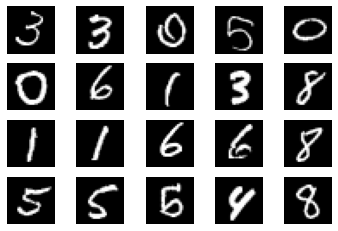

In [15]:
#show 20 random images from the data set
n_images = X_train.shape[0]
n_rows=4
n_cols=5

for i in range(1,n_rows*n_cols+1):
    im_idx = random.randint(0,n_images-1)
    pixels=X_train[im_idx]
    plt.subplot(n_rows, n_cols, i)
    plt.imshow(pixels, cmap='gray')
    plt.axis('off')

### Preprocesamiento de las imagenes
Aplicamos flatten 28*28 a cada imagen para generar un vector (784 característcias).

In [16]:
num_pixels = X_train.shape[1] * X_train.shape[2]

X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

X_train.shape,X_test.shape

((60000, 784), (10000, 784))

### Modelo basado en Naive Bayes


In [50]:
model = GaussianNB()

score = []
modelo = ['NaiveB','A. Decisión','Red Keras']
# Entrenar
#================================================================
model.fit(X_train,y_train)

GaussianNB()

In [51]:
# Score del modelo: NB
#================================================================
predicciones = model.predict(X_test)
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f"El porcentaje de clasificaciones correctas para el NB es: {round(100 * accuracy,2)} %")
score.append(round(100 * accuracy,2))

El porcentaje de clasificaciones correctas para el NB es: 55.58 %


### Modelo basado en decision tree

In [52]:
model_dt = DecisionTreeClassifier()

# Entrenar
#================================================================
model_dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [53]:
# Score del modelo: Arbol de decisión
#================================================================
predicciones = model_dt.predict(X_test)
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f"El porcentaje de clasificaciones correctas para el Arbol es: {round(100 * accuracy,2)} %")
score.append(round(100 * accuracy,2))
score.append(97.8)

El porcentaje de clasificaciones correctas para el Arbol es: 87.83 %


In [54]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
print(f"Profundidad del árbol: {model_dt.get_depth()}")
print(f"Número de nodos terminales: {model_dt.get_n_leaves()}")



Profundidad del árbol: 50
Número de nodos terminales: 3934


### Respuesta:

Se logra niveles de accuracy parecidos a lo obtenido por la red neuronal de Keras? Justifique su respuesta.

El modelo que se acerca al score de la red neuronal de keras es el árbol de decisión, el cual queda 10 puntos por debajo de este.

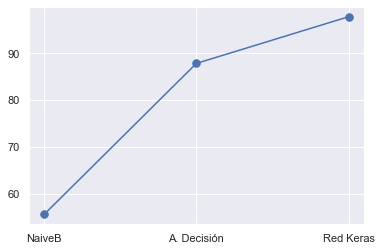

In [61]:
plt.plot(modelo,score,marker=".", markersize=15)

## Pregunta 2

Problema (Regresión): Aplicado al _Seoul Bike Sharing Demand Dataset_

**Objetivo**: Predecir Rented Bike Count

## Dependencias de librerías

In [1]:
from time import time
from pandas import read_csv, get_dummies
import matplotlib.pyplot as plt
from numpy import where, append

## Pre-processing functions
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## tensorflow-Keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics

## Funciones personalizadas

In [22]:
def plot_history(history, width=12, height=6):
  """
  DESCRIPTION:
    Historical performance of the keras model
  
  INPUT:
    @param history: history of performance of fitted model
    @type history: tensorflow.python.keras.callbacks.History

    @param width: width of the graphic display
    @type width: int

    @param height: height of the graphic display
    @type height: int

  OUTPUT:
    A graphic
  """

  ## Metrics keys stored in tensorflow object
  keys = list(history.history.keys())

  ## Number of epoch used for fit the model
  epoch = range(1, len(history.epoch) +1)

  ## Check if validation set was used.
  withValidation = False
  for key in keys:
    if 'val' in key:
      withValidation = True

  ## Number of metrics 
  nMetrics = len(keys)
  if withValidation:
    nMetrics = nMetrics//2

  ## Plot-space instance
  plt.figure(figsize=(width, height))

  for i in range(nMetrics):
    plt.subplot(nMetrics, 1, i+1)

    ## Plot (train) metric value
    labelMetric = keys[i]
    metric = history.history[keys[i]]
    plt.plot(epoch, metric, 'o-', label=labelMetric)

    if withValidation:
      ## Plot (validation) metric value
      labelMetricVal = keys[i+nMetrics]
      metricVal = history.history[keys[i+nMetrics]]
      plt.plot(epoch, metricVal, 'o-', label=labelMetricVal)

    plt.xlim(epoch[0], epoch[-1])
    plt.legend()
    plt.grid()

  plt.xlabel('Epoch')
  plt.show()
    

def build_model(x_input):
    model = Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(x_input,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

def search_hiper(x_input,grid):
    model = Sequential()
    #grid = {'Layers' : [8,12], 'neuronas':[16,32],'activa':['relu','tanh'],'Optimizer':['rmsprop','sgd']}
    # Capa Input + 1 dense
    model.add(layers.Dense(grid[1], activation=grid[2],input_shape=(x_input,)))
    for i in range(1,grid[0]):
        model.add(layers.Dense(grid[1], activation=grid[2]))
    model.add(layers.Dense(1)) # Output
    model.compile(optimizer=grid[3], loss='mse', metrics=['mae'])
    return model

## Carga y preprocesamiento de datos

Fuente: [Seoul Bike Sharing Demand Data Set](https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand) (UCI Repository)

In [3]:
## Load data
data = read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv',
               encoding='latin_1', parse_dates=['Date'])

In [4]:
data.shape

(8760, 14)

In [66]:
data.head(4)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [5]:
## Drop Date column
data.drop(columns=['Date'], inplace=True)

## Encoding: Holiday column in numeric values (0: No Holiday, 1: Holiday)
data['Holiday'] = where(data['Holiday'] == 'Holiday', 1, 0)

## Encoding: Functioning Day column in numeric values (0: No, 1: Yes)
data['Functioning Day'] = where(data['Functioning Day'] == 'Yes', 1, 0)

## Encoding: Seasons column using One-Hot encoding
data = get_dummies(data, drop_first=True)

In [6]:
data.head(4)

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Seasons_Spring,Seasons_Summer,Seasons_Winter
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,1,0,0,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,1,0,0,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,1,0,0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,1,0,0,1


In [23]:
## Data partition (hold-out validation)
trainValSet, testSet = train_test_split(data, train_size=0.85, random_state=0)
trainSet, valSet = train_test_split(trainValSet, train_size=0.85, random_state=0)

## Data standardization (this function return a numpy.ndarray)
scaler = StandardScaler().fit(trainSet)
trainSet_scaled = scaler.transform(trainSet)
valSet_scaled = scaler.transform(valSet)
testSet_scaled = scaler.transform(testSet)

## Predictors and target
X_train, y_train = trainSet_scaled[:, 1:], trainSet_scaled[:, 0]
X_val,   y_val =   valSet_scaled[:, 1:], valSet_scaled[:, 0]
X_test,  y_test =  testSet_scaled[:, 1:], testSet_scaled[:, 0]

_,X_Test,_, y_Test = train_test_split(X_test,  y_test, train_size=0.85, random_state=0)

## Shape of data
print('(train shape) X: {}, y: {}'.format(X_train.shape, y_train.shape))
print('(Validation shape) X: {}, y: {}'.format(X_val.shape, y_val.shape))
print('(test shape) X: {}, y: {}'.format(X_test.shape, y_test.shape))

(train shape) X: (6329, 14), y: (6329,)
(Validation shape) X: (1117, 14), y: (1117,)
(test shape) X: (1314, 14), y: (1314,)


In [24]:
X_Test.shape

(198, 14)

Genere un modelo predictivo mediante redes neuronales con capas Dense, para predecir el Rented Bike Count. Utilice el conjunto de entrenamiento y validación de la mejor forma tal de poder definir los hiperparámetros de una red neuronal (número de capas ocultas, número de unidades en las capas, funciones de activación, regularización, etc.). Una vez que haya definido la mejor configuración de la red neuronal, entrenela (con el conjunto de entrenamiento completo, i.e., train +val) y evalúe el desempeño en el conjunto de prueba, en particular entregue el mean absolute error y el mean squared error.

### Respuesta
Dado el tamaño del data set, lo cual implica un tiempo considerable para la validación/prueba de hiperparámetros, utilizaremos el set de validación para hacer el ajuste de estos. El número de pliegues a utilizar será de 4.

#### Ajuste de hiperparámetros
Número de epocas.

In [16]:
k = 4
num_val_samples = len(X_val) // k
num_epochs = 250
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = X_val[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_val[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [X_val[:i * num_val_samples],
         X_val[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_val[:i * num_val_samples],
         y_val[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model(X_val.shape[1])
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


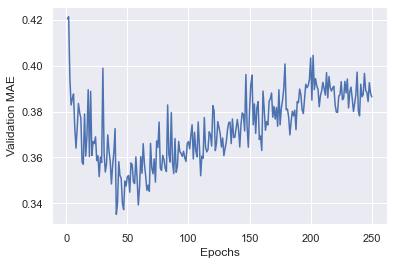

In [17]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Según el análisis de *epochs*, podemos utilizar un número de epocas igual a **50**.

In [26]:
# Ajustando Hiperparámetros
#===========================================================================================
k = 4
num_val_samples = len(X_val) // k
num_epochs = 50
best_model = []
best_mae = 10000000

#===========================================================================================
# Grid de Hiper
#===========================================================================================
grid = {'Layers' : [8,12], 'neuronas':[16,32],'activa':['relu','tanh'],'Optimizer':['rmsprop','sgd']}

#===========================================================================================
# Para cada pliegue
#===========================================================================================
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = X_val[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_val[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [X_val[:i * num_val_samples],
         X_val[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_val[:i * num_val_samples],
         y_val[(i + 1) * num_val_samples:]],
        axis=0)

    # Search Hiper
    #===============================================
    for layer in grid['Layers']:
        for neurona in grid['neuronas']:
            for actv in grid["activa"]:
                for opt in grid["Optimizer"]:
                    g=[layer,neurona,actv,opt]
                    print('hiper:',g)
                    # Build the Keras model (already compiled)
                    model = search_hiper(X_train.shape[1],g)
                    # Train the model (in silent mode, verbose=0)
                    history = model.fit(partial_train_data, partial_train_targets,
                                        validation_data=(val_data, val_targets),
                                         epochs=num_epochs, batch_size=1, verbose=0)
                    # Evaluate the model on the validation data
                    #===============================================
                    val_mse, val_mae = model.evaluate(X_Test, y_Test, verbose=0)
                    if val_mae<best_mae:
                        best_model = g
                        best_mae = val_mae


processing fold # 0
hiper: [8, 16, 'relu', 'rmsprop']
hiper: [8, 16, 'relu', 'sgd']
hiper: [8, 16, 'tanh', 'rmsprop']
hiper: [8, 16, 'tanh', 'sgd']
hiper: [8, 32, 'relu', 'rmsprop']
hiper: [8, 32, 'relu', 'sgd']
hiper: [8, 32, 'tanh', 'rmsprop']
hiper: [8, 32, 'tanh', 'sgd']
hiper: [12, 16, 'relu', 'rmsprop']
hiper: [12, 16, 'relu', 'sgd']
hiper: [12, 16, 'tanh', 'rmsprop']
hiper: [12, 16, 'tanh', 'sgd']
hiper: [12, 32, 'relu', 'rmsprop']
hiper: [12, 32, 'relu', 'sgd']
hiper: [12, 32, 'tanh', 'rmsprop']
hiper: [12, 32, 'tanh', 'sgd']
processing fold # 1
hiper: [8, 16, 'relu', 'rmsprop']
hiper: [8, 16, 'relu', 'sgd']
hiper: [8, 16, 'tanh', 'rmsprop']
hiper: [8, 16, 'tanh', 'sgd']
hiper: [8, 32, 'relu', 'rmsprop']
hiper: [8, 32, 'relu', 'sgd']
hiper: [8, 32, 'tanh', 'rmsprop']
hiper: [8, 32, 'tanh', 'sgd']
hiper: [12, 16, 'relu', 'rmsprop']
hiper: [12, 16, 'relu', 'sgd']
hiper: [12, 16, 'tanh', 'rmsprop']
hiper: [12, 16, 'tanh', 'sgd']
hiper: [12, 32, 'relu', 'rmsprop']
hiper: [12, 32, '

El mejor modelo es:

In [102]:
# Best model
#===============================================
label = ['Layers','No. Neuronas','F. Activación','F. de Optimización']
print('El mejor modelo:')
print('==============================================================')
for i in range(len(label)):
    print(label[i],' ==> ',best_model[i])

El mejor modelo:
Layers  ==>  8
No. Neuronas  ==>  32
F. Activación  ==>  tanh
F. de Optimización  ==>  rmsprop


Una vez que haya definido la mejor configuración de la red neuronal, entrenela (con el conjunto de entrenamiento completo, i.e., train +val) y evalúe el desempeño en el conjunto de prueba, en particular entregue el mean absolute error y el mean squared error.

In [103]:
# Crear el modelo final
#=========================================================
model = search_hiper(X_train.shape[1],best_model)

In [104]:
# Entrenamos con todo el set de entrenamiento
#===========================================================================================
history=model.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=num_epochs, batch_size=1, verbose=1)

Epoch 1/50
6329/6329 [==============================] - 7s 937us/step - loss: 0.3869 - mae: 0.4383 - val_loss: 0.3174 - val_mae: 0.3989
Epoch 2/50
6329/6329 [==============================] - 6s 943us/step - loss: 0.3141 - mae: 0.3863 - val_loss: 0.2906 - val_mae: 0.3484
Epoch 3/50
6329/6329 [==============================] - 6s 920us/step - loss: 0.2762 - mae: 0.3605 - val_loss: 0.2919 - val_mae: 0.3472
Epoch 4/50
6329/6329 [==============================] - 6s 924us/step - loss: 0.2554 - mae: 0.3469 - val_loss: 0.2628 - val_mae: 0.3531
Epoch 5/50
6329/6329 [==============================] - 6s 900us/step - loss: 0.2448 - mae: 0.3339 - val_loss: 0.2567 - val_mae: 0.3268
Epoch 6/50
6329/6329 [==============================] - 6s 944us/step - loss: 0.2379 - mae: 0.3290 - val_loss: 0.2124 - val_mae: 0.3060
Epoch 7/50
6329/6329 [==============================] - 6s 948us/step - loss: 0.2242 - mae: 0.3184 - val_loss: 0.2170 - val_mae: 0.2960
Epoch 8/50
6329/6329 [==========================

In [106]:
# Las métrcias
#=========================================================
val_mse, val_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Metricas para el modelo: MAE = {val_mae} --- MSE = {val_mse}")

Metricas para el modelo: MAE = 0.3031015694141388 --- MSE = 0.19194364547729492


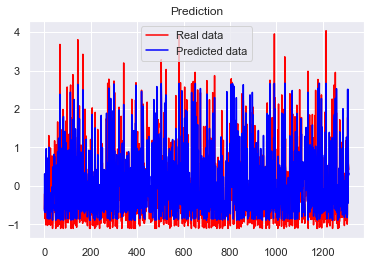

In [109]:
# Gráfico del valor estimado y el valor real
#=========================================================
y_pred = model.predict(X_test)

plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

In [113]:
# El R2
#=========================================================
print(f"R2 {round(100*r2(y_test,y_pred),2)}%")

R2 81.47%


El gráfico del historico del train

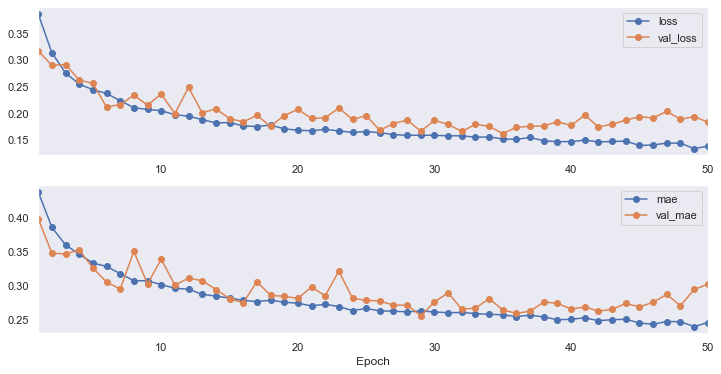

In [114]:
# Evolución del entrenamiento
#=========================================================
plot_history(history)

## Suerte!